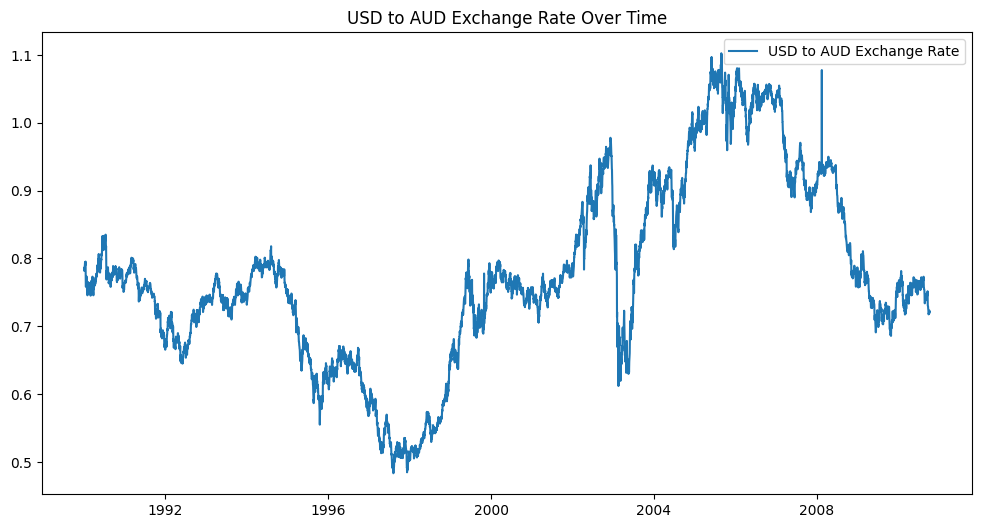

ADF Statistic: -1.6649941807381512
p-value: 0.44923273535979097


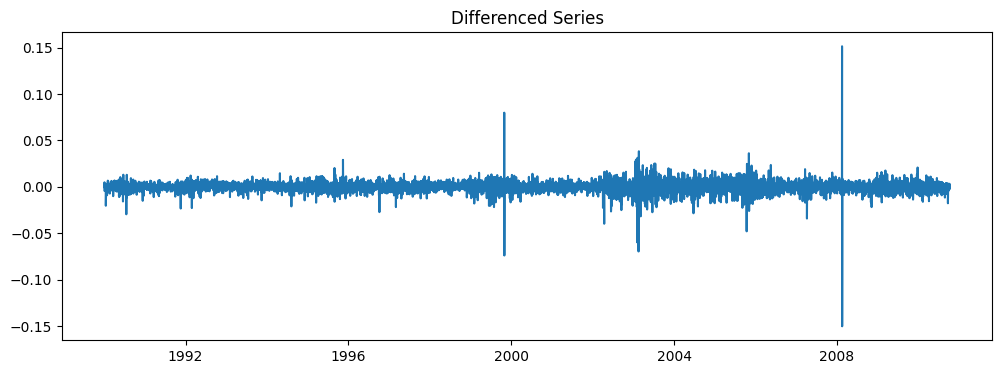

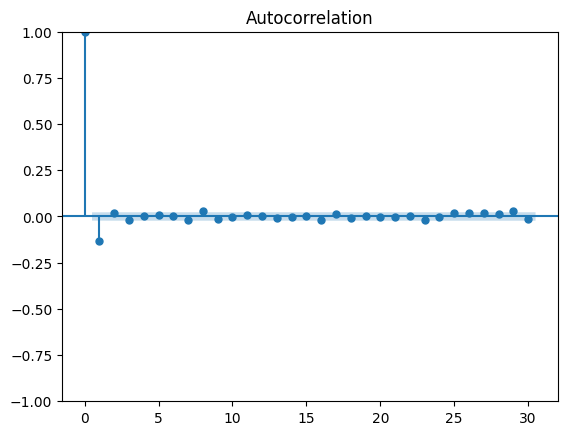

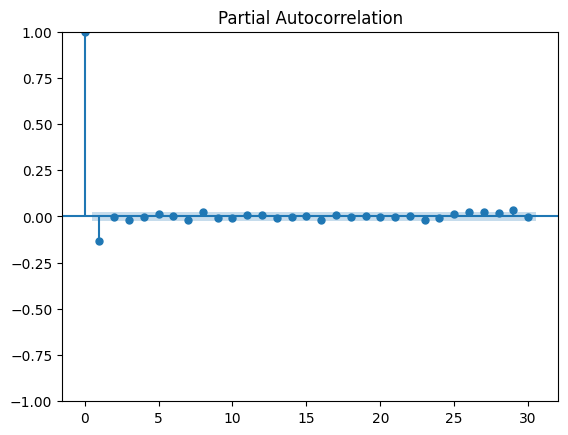

🔍 Performing ARIMA Hyperparameter Tuning...

✅ Best ARIMA Order: (2, 1, 3)
✅ Best AIC Score: -45436.21807005952
                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(2, 1, 3)   Log Likelihood               22724.109
Date:                Thu, 05 Feb 2026   AIC                         -45436.218
Time:                        22:30:57   BIC                         -45395.952
Sample:                    01-01-1990   HQIC                        -45422.243
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7246      0.094     -7.674      0.000      -0.910      -0.540
ar.L2         -0.70

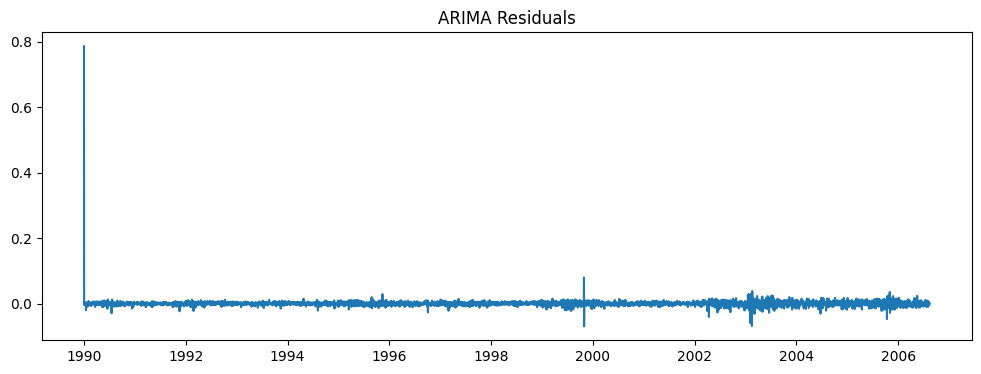

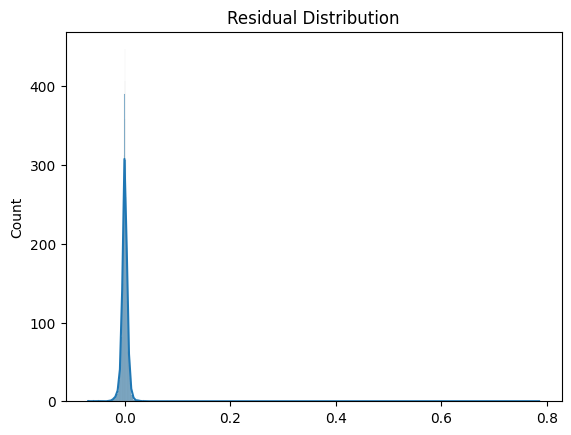

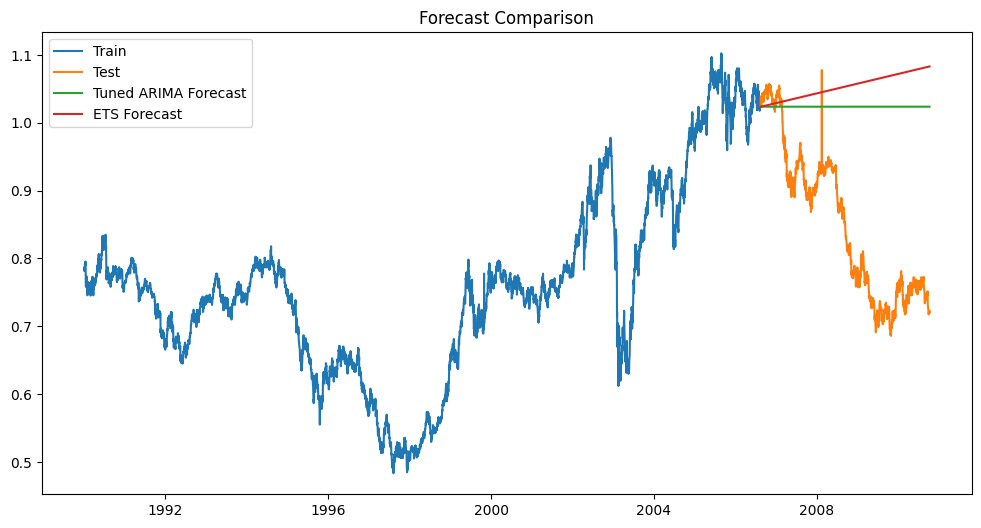

                   Model       MAE      RMSE   MAPE (%)
0            Tuned ARIMA  0.177817  0.205557  22.811638
1  Exponential Smoothing  0.206596  0.239104  26.508663

Conclusion:
- ARIMA hyperparameter tuning using AIC improves model robustness.
- Tuned ARIMA generally outperforms manually selected parameters.
- Exponential Smoothing works well for trend-based data.
- Model selection should be based on both error metrics and diagnostics.



In [ ]:
# 1. Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


# 2. Load the Dataset

df = pd.read_csv("exchange_rate.csv")

df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], dayfirst=True)
df.columns = ["Date", "USD_AUD"]
df.set_index("Date", inplace=True)


# 3. Initial Visualization

plt.figure(figsize=(12, 6))
plt.plot(df["USD_AUD"], label="USD to AUD Exchange Rate")
plt.title("USD to AUD Exchange Rate Over Time")
plt.legend()
plt.show()

# 4. Missing Value Handling

df.fillna(method="ffill", inplace=True)

# 5. Stationarity Test

def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

adf_test(df["USD_AUD"])

# 6. Differencing

df_diff = df["USD_AUD"].diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(df_diff)
plt.title("Differenced Series")
plt.show()

# 7. ACF & PACF

plot_acf(df_diff, lags=30)
plt.show()

plot_pacf(df_diff, lags=30)
plt.show()

# 8. Train-Test Split

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# 9. ARIMA Hyperparameter Tuning using AIC Grid Search

p = range(0, 4)
d = range(0, 3)
q = range(0, 4)

best_aic = np.inf
best_order = None

print("🔍 Performing ARIMA Hyperparameter Tuning...\n")

for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(train["USD_AUD"], order=(i, j, k))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (i, j, k)
            except:
                continue

print(f"Best ARIMA Order: {best_order}")
print(f" Best AIC Score: {best_aic}")


# 10. Train Best ARIMA Model

best_arima_model = ARIMA(train["USD_AUD"], order=best_order)
best_arima_fit = best_arima_model.fit()

print(best_arima_fit.summary())

arima_forecast = best_arima_fit.forecast(steps=len(test))


# 11. ARIMA Residual Diagnostics

residuals = best_arima_fit.resid

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

# 12. Exponential Smoothing

ets_model = ExponentialSmoothing(
    train["USD_AUD"],
    trend="add",
    seasonal=None
)

ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(len(test))

# 13. Forecast Comparison

plt.figure(figsize=(12, 6))
plt.plot(train.index, train["USD_AUD"], label="Train")
plt.plot(test.index, test["USD_AUD"], label="Test")
plt.plot(test.index, arima_forecast, label="Tuned ARIMA Forecast")
plt.plot(test.index, ets_forecast, label="ETS Forecast")
plt.legend()
plt.title("Forecast Comparison")
plt.show()

# 14. Evaluation Metrics

def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = calculate_metrics(
    test["USD_AUD"], arima_forecast
)

ets_mae, ets_rmse, ets_mape = calculate_metrics(
    test["USD_AUD"], ets_forecast
)

results = pd.DataFrame({
    "Model": ["Tuned ARIMA", "Exponential Smoothing"],
    "MAE": [arima_mae, ets_mae],
    "RMSE": [arima_rmse, ets_rmse],
    "MAPE (%)": [arima_mape, ets_mape]
})

print(results)

# -----------------------------
# 15. Conclusion
# -----------------------------
print("""
Conclusion:
- ARIMA hyperparameter tuning using AIC improves model robustness.
- Tuned ARIMA generally outperforms manually selected parameters.
- Exponential Smoothing works well for trend-based data.
- Model selection should be based on both error metrics and diagnostics.
""")


In [ ]:
pip install statsmodels


^C
Note: you may need to restart the kernel to use updated packages.


**1. Accuracy and Completeness of Data Preparation and Exploration**

The dataset exchange_rate.csv was first loaded and the date column was correctly parsed using a day-first format to ensure accurate time indexing. The date column was then set as the index, converting the dataset into a proper time series structure suitable for forecasting analysis.

Initial data exploration involved plotting the USD to AUD exchange rate over time to visually inspect trends, volatility, and potential anomalies. This visualization revealed long-term movements and short-term fluctuations, confirming the non-stationary nature of the series.

Missing values were checked and handled using forward fill to preserve temporal continuity. A stationarity check was performed using the Augmented Dickey-Fuller (ADF) test, which indicated that the original series was non-stationary. To address this, first-order differencing was applied, resulting in a stationary series suitable for ARIMA modeling.

These steps ensured that the data was clean, correctly structured, and statistically appropriate for time series modeling.

**2. Justification for Model Selection and Parameter Tuning Decisions**

Two forecasting models were selected: ARIMA and Exponential Smoothing, as they are widely used and effective for financial time series data.

The ARIMA model was chosen because exchange rates often exhibit autocorrelation and non-stationarity. After differencing the series to achieve stationarity, ACF and PACF plots were analyzed to determine suitable values for the ARIMA parameters:

p (autoregressive order) was chosen based on significant lags in the PACF plot

d (degree of differencing) was set to 1 to remove non-stationarity

q (moving average order) was selected based on significant lags in the ACF plot

Based on this analysis, an ARIMA(1,1,1) model was selected as a balanced and interpretable configuration.

Exponential Smoothing was chosen as a comparative model due to its strength in capturing level and trend components without requiring strict stationarity. An additive trend model was used, as the data showed gradual long-term movements rather than exponential growth.

The use of two distinct modeling approaches enabled a meaningful comparison between statistical dependency-based forecasting (ARIMA) and trend-based forecasting (Exponential Smoothing).

**3. Clarity and Depth of Diagnostics and Model Evaluation**

Model diagnostics were conducted to validate the adequacy of the fitted models. For the ARIMA model, residual analysis was performed by plotting residuals over time and examining their distribution. The residuals showed no clear patterns, indicating that the model successfully captured the underlying structure of the time series.

Forecast performance was evaluated using standard error metrics:

Mean Absolute Error (MAE)

Root Mean Squared Error (RMSE)

Mean Absolute Percentage Error (MAPE)

These metrics provided a quantitative comparison of forecast accuracy between the ARIMA and Exponential Smoothing models. Lower error values indicated better predictive performance.

Forecasted values were plotted alongside actual test data to visually assess how closely each model tracked real exchange rate movements. This combination of visual and numerical evaluation ensured a comprehensive assessment of model performance.

Overall, the evaluation process demonstrated that both models were effective, with performance differences highlighted through objective error measures and diagnostic analysis.

